## 프로젝트 01
- 데이터는 kaggle에 나오는 LoanDefault 데이터 활용
  - https://www.kaggle.com/datasets/yasserh/loan-default-dataset/data
  - kaggle에서 해당 데이터 출처 확인했으나, 본 수업에서는 이미 csv파일이 제공됨
- 실습 시에는 colab에 csv파일 올려서 작업함
- 여기서는 (편의상) EDA 부분은 jupyterlab에서 interactive하게 진행함
  - 전처리 함수나 class 정의하기 위해 컬럼별 시각화, 결측치/이상치 확인
- 강사님께서 sklearn, torch 둘 중에 하나만 해도 된다고 하셔서, sklearn을 우선 해보고 여유가 있으면 torch 시도
  - 이번 주 실습은 EDA/전처리/Logistic이 목적이므로, sklearn 우선시함



### 01 Library & HyperParameter Defintion

#### 01-01) 라이브러리, 데이터 불러오기

In [70]:
# 필요한 라이브러리 불러오기
import numpy as np # numpy(숫자 계산, 수학) 라이브러리
import pandas as pd # pandas(데이터프레임 처리) 라이브러리
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler # scaling 모듈 불러오기
from sklearn.model_selection import train_test_split # sklearn.model_selection에서 train_test_split 모듈 불러오기
from sklearn.linear_model import LogisticRegression # 로지스틱 모형 불러오기
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score # 모델 평가지표(accuracy, precision, recall, f1_score)
import matplotlib.pyplot as plt # 시각화 라이브러리-1
import seaborn as sns # 시각화 라이브러리-2

# 컬럼명 처리 관련 라이브러리 및 함수정의
import re
def clean_feature_names(columns):
    return [re.sub(r"[<>\[\]]", "_", col) for col in columns]

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os

base_path = '/content/drive/MyDrive/AI_serivce_track/Week_01'

# 정확한 이름으로 다시 할당
data_path = os.path.join(base_path, 'Loan_Default.csv')
Loan_Default_df = pd.read_csv(data_path)
Loan_Default_df.shape

(148670, 34)

#### 01-02) hyper-parameter 정의

In [38]:
# hyper-parameter definition

# 변수 선택 및 train/test 비율 관련
target_var = 'Status' # y에 해당하는 변수
delete_var = ['ID','year','credit_type_EQUI'] # 불필요한 변수
# credit_type_EQUI에 의해 완전히 변수가 분리되어서 random-forest 모든 성능지표가 1을 찍음
test_rate = 0.2 # test 데이터셋 비율
random_state = 42 # random_state 지정 (train_test_split에 활용)

# 전처리 Class 관련 hyper-parameter
missing_value_rate = 0.01 # 1% 이상이면 범주/수치 상관없이 해당 값 삭제
skewness_abs_criterion = 2 # skewness 절대값이 2 넘어가면(결측치가 missing_value_rate 이상이고), log1p변환 후 impute!
scaling_method = 'standard' # ('standard','min_max','robust','None' 중 입력) # None으로 입력하나 scaling_method 지우나 결과는 같음

### 02 EDA + Sampling
- 03에서 '전처리' class나 함수 정의 하기 위해 EDA 수행
  - missing value가 어느 정도 비율(예: 1%)이면 무시하고 삭제할지
  - missing value가 (1% 이상이고) 범주형이라면?
    - 'Unknown'이나 'Missing'으로 채우고 나중에 one-hot-encoding
  - missing value가 (1% 이상이고) 수치형이라면?
- 특이한 컬럼 'age'
  - age구간별로 status(default 할지 안할지) 관련 있는지 확인 필요

In [5]:
Loan_Default_df.columns

Index(['ID', 'year', 'loan_limit', 'Gender', 'approv_in_adv', 'loan_type',
       'loan_purpose', 'Credit_Worthiness', 'open_credit',
       'business_or_commercial', 'loan_amount', 'rate_of_interest',
       'Interest_rate_spread', 'Upfront_charges', 'term', 'Neg_ammortization',
       'interest_only', 'lump_sum_payment', 'property_value',
       'construction_type', 'occupancy_type', 'Secured_by', 'total_units',
       'income', 'credit_type', 'Credit_Score', 'co-applicant_credit_type',
       'age', 'submission_of_application', 'LTV', 'Region', 'Security_Type',
       'Status', 'dtir1'],
      dtype='object')

In [6]:
Loan_Default_df.head(n=7) # 원래 기본값이 n=5 임

,ID,year,loan_limit,Gender,approv_in_adv,loan_type,loan_purpose,Credit_Worthiness,open_credit,business_or_commercial,...,credit_type,Credit_Score,co-applicant_credit_type,age,submission_of_application,LTV,Region,Security_Type,Status,dtir1
0,24890,2019,cf,Sex Not Available,nopre,type1,p1,l1,nopc,nob/c,...,EXP,758,CIB,25-34,to_inst,98.728814,south,direct,1,45.0
1,24891,2019,cf,Male,nopre,type2,p1,l1,nopc,b/c,...,EQUI,552,EXP,55-64,to_inst,NaN,North,direct,1,NaN
2,24892,2019,cf,Male,pre,type1,p1,l1,nopc,nob/c,...,EXP,834,CIB,35-44,to_inst,80.019685,south,direct,0,46.0
3,24893,2019,cf,Male,nopre,type1,p4,l1,nopc,nob/c,...,EXP,587,CIB,45-54,not_inst,69.376900,North,direct,0,42.0
4,24894,2019,cf,Joint,pre,type1,p1,l1,nopc,nob/c,...,CRIF,602,EXP,25-34,not_inst,91.886544,North,direct,0,39.0
5,24895,2019,cf,Joint,pre,type1,p1,l1,nopc,nob/c,...,EXP,864,EXP,35-44,not_inst,70.089286,North,direct,0,40.0
6,24896,2019,cf,Joint,pre,type1,p3,l1,nopc,nob/c,...,EXP,860,EXP,55-64,to_inst,79.109589,North,direct,0,44.0


In [7]:
Loan_Default_df.info() # 148670이 전체 크기,

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148670 entries, 0 to 148669
Data columns (total 34 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   ID                         148670 non-null  int64  
 1   year                       148670 non-null  int64  
 2   loan_limit                 145326 non-null  object 
 3   Gender                     148670 non-null  object 
 4   approv_in_adv              147762 non-null  object 
 5   loan_type                  148670 non-null  object 
 6   loan_purpose               148536 non-null  object 
 7   Credit_Worthiness          148670 non-null  object 
 8   open_credit                148670 non-null  object 
 9   business_or_commercial     148670 non-null  object 
 10  loan_amount                148670 non-null  int64  
 11  rate_of_interest           112231 non-null  float64
 12  Interest_rate_spread       112031 non-null  float64
 13  Upfront_charges            10

#### 02-01 불필요한 변수 식별
- ID는 모델 예측에 불필요함
- year 확인해보니 2019년만 있음 (삭제 가능)

In [8]:
# year변수 확인해보기
Loan_Default_df['year'].value_counts()

,count
year,
2019,148670


#### 02-02 데이터 시각화
- 결측치 처리 방법 정할 목적의 '시각화'

In [9]:
# 결측치 비율 확인
Loan_Default_df.isnull().mean()

,0
ID,0.000000
year,0.000000
loan_limit,0.022493
Gender,0.000000
approv_in_adv,0.006107
loan_type,0.000000
loan_purpose,0.000901
Credit_Worthiness,0.000000
open_credit,0.000000
business_or_commercial,0.000000


In [10]:
# 결측치 비율, 데이터타입 결합

null_ratio = Loan_Default_df.isnull().mean() # 결측치 비율
dtypes = Loan_Default_df.dtypes

# 데이터프레임으로 병합
summary = pd.DataFrame({
    'missing_ratio': null_ratio,
    'dtype': dtypes
})

# 비율 내림차순 정렬 (선택)
summary = summary.sort_values(by='missing_ratio', ascending=False)

summary.head(10)  # 상위 10개만 보기

,missing_ratio,dtype
Upfront_charges,0.266644,float64
Interest_rate_spread,0.246445,float64
rate_of_interest,0.245100,float64
dtir1,0.162245,float64
property_value,0.101554,float64
LTV,0.101554,float64
income,0.061546,float64
loan_limit,0.022493,object
approv_in_adv,0.006107,object
age,0.001345,object


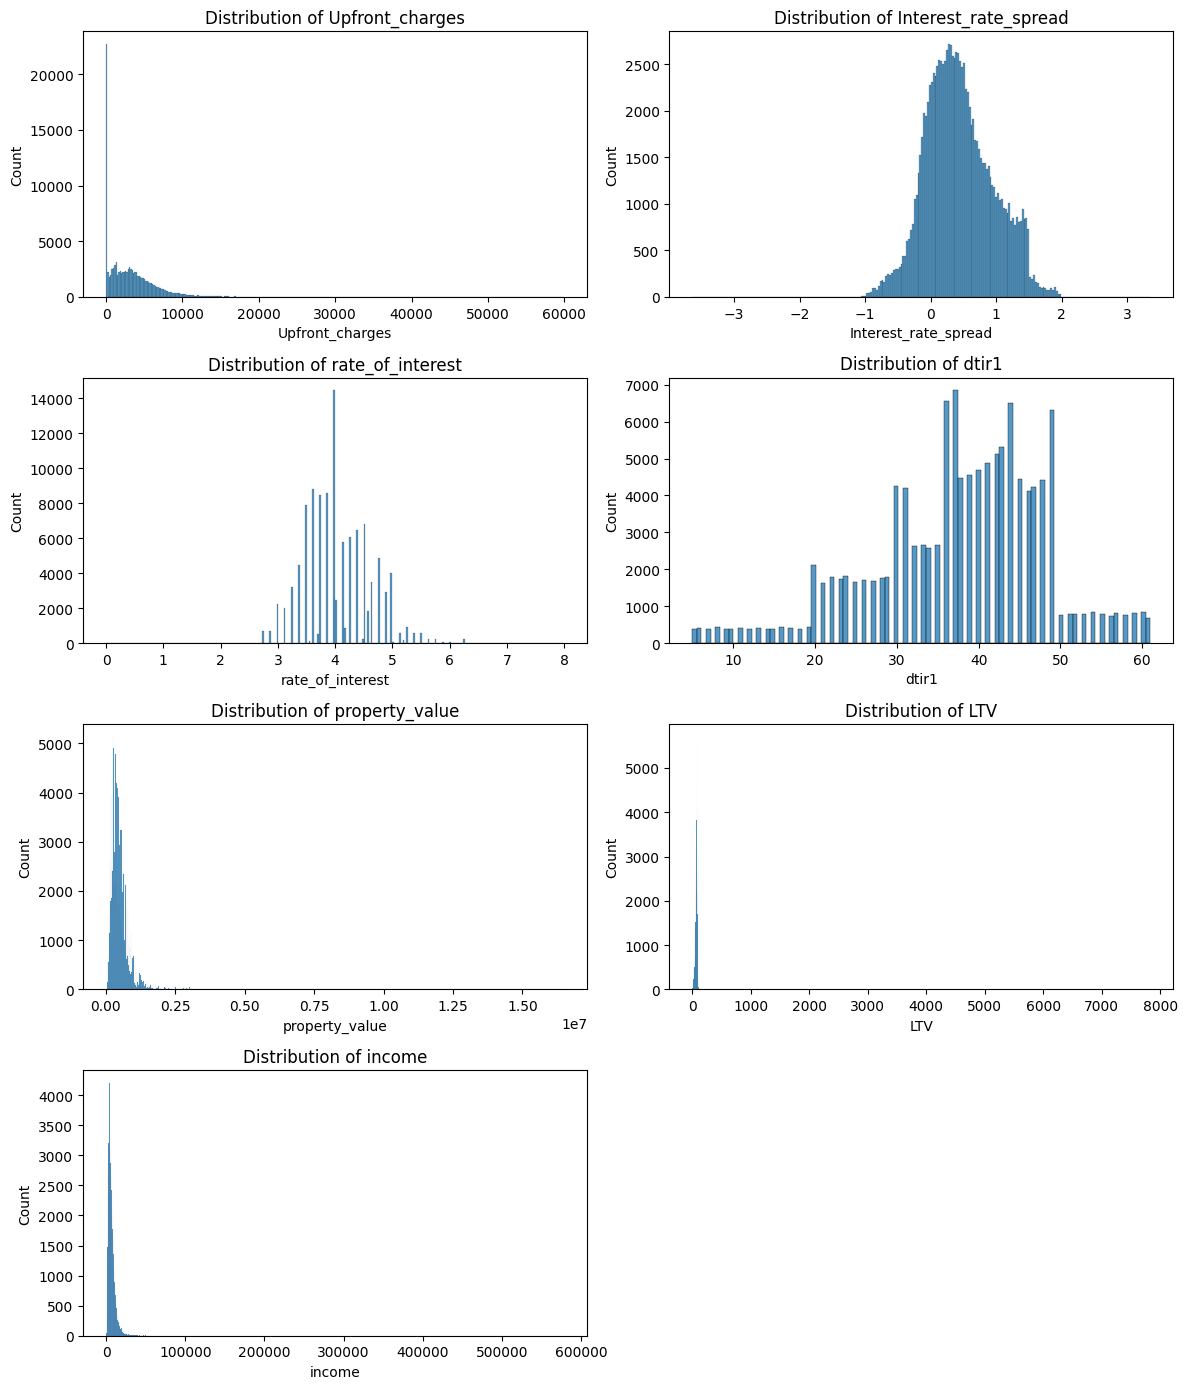

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# 수치형/결측치 많은 7개 체크
col_list = ['Upfront_charges','Interest_rate_spread','rate_of_interest','dtir1','property_value','LTV','income']

# subplot 설정 (4행 2열)
fig, axes = plt.subplots(4, 2, figsize=(12, 14))
axes = axes.flatten()  # 2D -> 1D array

# 각 컬럼별 히스토그램 그리기
for i, col in enumerate(col_list):
    sns.histplot(Loan_Default_df[col], ax=axes[i], kde=False)
    axes[i].set_title(f"Distribution of {col}")

# 빈 subplot 지우기 (마지막 칸)
for j in range(len(col_list), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# Upfront_charges, property_value, LTV, income -> 심하게 기울어져 있으므로 log변환(log1p) 해서 missing-value채우기
# Interest_rate_spread, rate_of_interest, dtir1 -> 중간값으로 채워도 될 듯

In [12]:
# (참고) 클래스 전처리 로직 확립 목적으로 수치형 컬럼 skewness계산
# 수치형 컬럼만 추출
num_cols = Loan_Default_df.select_dtypes(include=['float64', 'int64']).columns
# skewness 계산
skew_vals = Loan_Default_df[num_cols].skew()

# 보기 좋게 정리 (절댓값 내림차순 정렬)
skew_summary = skew_vals.abs().sort_values(ascending=False).to_frame(name='abs_skew')

# 원래 skewness 값도 같이 보기
skew_summary['skew'] = skew_vals[skew_summary.index]

skew_summary

,abs_skew,skew
LTV,120.615337,120.615337
income,17.307695,17.307695
property_value,4.586276,4.586276
term,2.174822,-2.174822
Upfront_charges,1.754076,1.754076
loan_amount,1.666998,1.666998
Status,1.176762,1.176762
dtir1,0.551465,-0.551465
rate_of_interest,0.388406,0.388406
Interest_rate_spread,0.280762,0.280762


In [13]:
Loan_Default_df['loan_limit'].value_counts()

,count
loan_limit,
cf,135348
ncf,9978


In [14]:
Loan_Default_df['submission_of_application'].value_counts() # to_inst, not_inst

,count
submission_of_application,
to_inst,95814
not_inst,52656


In [15]:
Loan_Default_df['age'].value_counts()

,count
age,
45-54,34720
35-44,32818
55-64,32534
65-74,20744
25-34,19142
>74,7175
<25,1337


In [16]:
pd.crosstab(Loan_Default_df['age'], Loan_Default_df['Status'], normalize='index')

Status,0,1
age,,
25-34,0.778080,0.221920
35-44,0.777287,0.222713
45-54,0.759533,0.240467
55-64,0.741132,0.258868
65-74,0.731440,0.268560
<25,0.710546,0.289454
>74,0.699930,0.300070


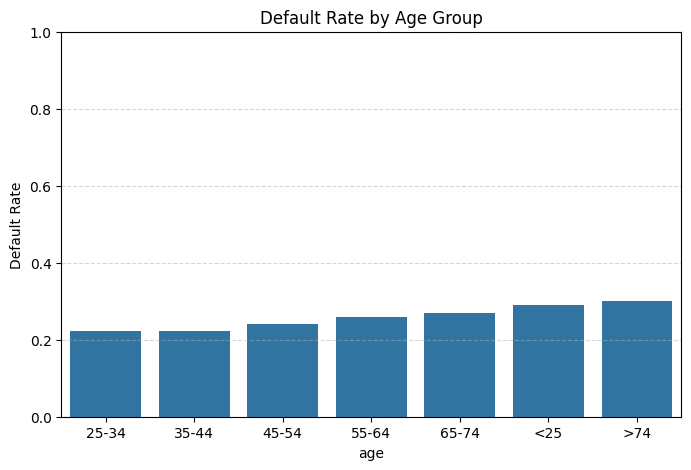

In [17]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 교차표로 default 비율 계산
age_default_rate = pd.crosstab(Loan_Default_df['age'], Loan_Default_df['Status'], normalize='index')[1]

# 시리즈 → DataFrame 변환
age_default_rate = age_default_rate.reset_index().rename(columns={1: 'default_rate'})

# 막대그래프 시각화
plt.figure(figsize=(8, 5))
sns.barplot(data=age_default_rate, x='age', y='default_rate', order=sorted(age_default_rate['age']))
plt.ylabel("Default Rate")
plt.title("Default Rate by Age Group")
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

### 03 Data Pre-Procssing - 데이터 전처리
- (including Spliting Balanced Train/Test Dataset)


#### 03-01 전처리 클래스 정의 및 적용
- 전처리 클래스 정의?
  - 불필요 컬럼 삭제
  - 결측치 비율, 데이터 타입 따른 전처리 로직
    - 결측치(1%)미만, 수치형 -> 제거
    - 결측치(1%)미만, 범주형 -> 제거
    - 결측치(1%)이상, 수치형 -> 중간값 또는 skewness심하면 log1p 변환
    - 결측치(1%)이상, 범주형 -> 'Unknown'이나 'Missing'으로 처리

In [71]:
class DataPreprocessor:
  def __init__(self,target_var,delete_var=None, test_rate=0.2, random_state=42,
               missing_value_rate=0.01, skewness_abs_criterion=2, log_transform_cols=None,scaling_method=None):
    # class 정의할 때 test_rate=0.2 처럼 초기값을 입력해줘야함
    # 외부에서 정한 값을 직접 참조하는 구조가 아님
    self.target_var = target_var
    self.delete_var = delete_var if delete_var else []
    self.test_rate = test_rate
    self.random_state = random_state
    self.missing_value_rate = missing_value_rate
    self.skewness_abs_criterion = skewness_abs_criterion
    self.log_transform_cols = log_transform_cols if log_transform_cols is not None else []
    self.scaling_method = scaling_method.lower() if scaling_method else None

  def fit_transform(self, df):
    # fit_transform이라는 매서드 정의
    df = df.copy() # pandas warning방지 차원에서 .copy()

    # 1. Drop delete_vars, 불필요한 컬럼 제거
    df.drop(columns = self.delete_var, inplace = True, errors = 'ignore')

    # 2. Separate target
    y = df[self.target_var]  # 수정됨
    df.drop(columns=[self.target_var], inplace=True)  # 수정됨

    # 3. Column type 나누기(수치형, 범주형)
    num_cols = df.select_dtypes(include = ['float64','int64']).columns
    cat_cols = df.select_dtypes(include = ['object']).columns

    # 4. log1p 대상 자동 판단 (없으면)
    if not self.log_transform_cols:
      skewed = df[num_cols].skew().abs()
      self.log_transform_cols = skewed[skewed > self.skewness_abs_criterion].index.tolist()

    # 5. 결측 비율 기준 행 제거
    missing_ratio = df.isnull().mean()
    cols_to_dropna = missing_ratio[missing_ratio < self.missing_value_rate].index.tolist()
    df.dropna(subset=cols_to_dropna, inplace=True)  # 수정됨
    y = y.loc[df.index]  # 수정됨: row 삭제 후 target 재정렬

    # 6. 남은 결측치 처리
    for col in df.columns:
      if col in num_cols:
        if col in self.log_transform_cols:
          df[col] = df[col].clip(lower=0)  # 수정됨: 음수 방지
          df[col] = np.log1p(df[col])
        df[col] = df[col].fillna(df[col].median())
      elif col in cat_cols:
        df[col] = df[col].fillna("Missing_value")

    # 7. 범주형 변수 One-Hot 인코딩
    df_cat = pd.get_dummies(df[cat_cols], drop_first=True)
    df_num = df[num_cols]

    # 8. Scaling 선택적
    if self.scaling_method:
      if self.scaling_method=='standard':
        scaler = StandardScaler()
      elif self.scaling_method=='min_max':
        scaler = MinMaxScaler()
      elif self.scaling_method=='robust':
        scaler = RobustScaler()
      else:
        raise ValueError("Unsupported scaling_method. Choose from 'standard', 'min_max', 'robust', or None.")

    # 9. 피처 조합
    X = pd.concat([df_num, df_cat], axis=1) # y는 앞에서 정의함

    # 🔧 컬럼 이름 정제(xg-boost feature문제 때)
    X.columns = clean_feature_names(X.columns)

    # 10. train-test split
    return train_test_split(X, y, test_size=self.test_rate,
                            random_state=self.random_state, stratify=y)


In [19]:
prep = DataPreprocessor(
    target_var='Status',
    delete_var=['ID', 'year'],
    test_rate=0.2,
    random_state=42,
    missing_value_rate=0.01,
    skewness_abs_criterion=2
)

In [20]:
X_train, X_test, y_train, y_test = prep.fit_transform(Loan_Default_df)

### 04 Informations Related Logistic Regression Definition + Train/Test
- 처음에 수렴을 안해서 scaling(standard) 했음에도 수렴 안함
- solver를 변경함(lbfgs -> saga로)

#### 04-01 scaling의 영향 확인
- scaling 미적용 시
  - max_iter = 3000까지 했음에도 수렴하지 않는다는 warning이 나옴
    - 다시 실행해보면 안나올 때도 있음
  - 성능(소모시간 82.7초)
    - Accuracy : 0.8687
    - Precision : 0.8837
    - Recall : 0.5330
    - F1-score : 0.6653
- scaling 적용 시(class 수정함)
  - 성능은 위와 동등(소모시간 83.2초 -> 재실행하니 91초)
- solver 변경
  - lbfgs 대신 'saga'로 solver변경
  - 성능(소모시간 590초)
    - Accuracy : 0.4902
    - Precision : 0.2408
    - Recall : 0.501
    - F1 score : 0.3203
- 과적합 방지 목적 변수 제거 후
  - 성능(77.91초)
    - Accuracy : 0.8713
    - Precision : 0.9188
    - Recall : 0.5212
    - F1 score : 0.6651

In [21]:
from sklearn.linear_model import LogisticRegression # 로지스틱 모형 불러오기
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score # 모델 평가지표(accuracy, precision, recall, f1_score)
import time

st = time.time()
num_iter= 3000 # 1000번 하니 warning나옴

lr_clf = LogisticRegression(max_iter = num_iter, n_jobs=-1)
lr_clf.fit(X_train, y_train)
lr_pred = lr_clf.predict(X_test)

ed = time.time()

print(f'소모시간 : {round(ed-st,2)}초')
print(f'number_of_iteration : {num_iter}')
print('\n')
print("Accuracy:", round(accuracy_score(y_test, lr_pred),4))
print("Precision:", round(precision_score(y_test, lr_pred),4))
print("Recall:", round(recall_score(y_test, lr_pred),4))
print("F1 Score:", round(f1_score(y_test, lr_pred),4))


소모시간 : 82.72초
number_of_iteration : 3000


Accuracy: 0.8685
Precision: 0.8851
Recall: 0.533
F1 Score: 0.6653


##### standard-scaling 적용

In [26]:
prep = DataPreprocessor(
    target_var='Status',
    delete_var=['ID', 'year'],
    test_rate=0.2,
    random_state=42,
    missing_value_rate=0.01,
    skewness_abs_criterion=2,
    scaling_method = 'standard'
)

X_train, X_test, y_train, y_test = prep.fit_transform(Loan_Default_df)

In [27]:
from sklearn.linear_model import LogisticRegression # 로지스틱 모형 불러오기
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score # 모델 평가지표(accuracy, precision, recall, f1_score)
import time

st = time.time()
num_iter= 3000 # 1000번 하니 warning나옴

lr_clf = LogisticRegression(max_iter = num_iter, n_jobs=-1)
lr_clf.fit(X_train, y_train)
lr_pred = lr_clf.predict(X_test)

ed = time.time()

print(f'소모시간 : {round(ed-st,2)}초')
print(f'number_of_iteration : {num_iter}')
print('\n')
print("Accuracy:", round(accuracy_score(y_test, lr_pred),4))
print("Precision:", round(precision_score(y_test, lr_pred),4))
print("Recall:", round(recall_score(y_test, lr_pred),4))
print("F1 Score:", round(f1_score(y_test, lr_pred),4))

소모시간 : 91.22초
number_of_iteration : 3000


Accuracy: 0.8685
Precision: 0.8851
Recall: 0.533
F1 Score: 0.6653


##### 변수 조정
- 5개 변수 제거(random-forest 모든 성능지표가 1이 나옴)
  - 그렇다면 저 변수는 '정답을 알고 있는' 변수 이므로 data_leakage에 해당

In [79]:
prep = DataPreprocessor(
    target_var='Status',
    delete_var=['ID', 'year','credit_type_EQUI','Interest_rate_spread','Upfront_charges','Secured_by','Security_Type'],
    test_rate=0.2,
    random_state=42,
    missing_value_rate=0.01,
    skewness_abs_criterion=2,
    scaling_method = 'standard'
)
## Random-Forest 성능지표가 모두 1을 찍어서 변수 조정

## 아래 변수들은 사실상 모형에 정답을 알려주는 변수(over-fitting문제)
# credit_type_EQUI	target이 1일 때만 등장
# Interest_rate_spread	값 하나로 거의 이진 분리 가능
# Upfront_charges	희귀값에서 완전분리 다수
# Secured_by	"land" → 모두 불량 (Status=1), 심각한 규칙성
# Security_Type	"Indriect"일 경우 모두 default

# 위 다섯 변수가 다 들어가 있는 경우 모든 성능지표가 1을 찍음

X_train, X_test, y_train, y_test = prep.fit_transform(Loan_Default_df)

In [80]:
from sklearn.linear_model import LogisticRegression # 로지스틱 모형 불러오기
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score # 모델 평가지표(accuracy, precision, recall, f1_score)
import time

st = time.time()
num_iter= 3000 # 1000번 하니 warning나옴

lr_clf_final = LogisticRegression(max_iter = num_iter, n_jobs=-1)
lr_clf_final.fit(X_train, y_train)
lr_pred_final = lr_clf_final.predict(X_test)

ed = time.time()

print(f'소모시간 : {round(ed-st,2)}초')
print(f'number_of_iteration : {num_iter}')
print('\n')
print("Accuracy:", round(accuracy_score(y_test, lr_pred_final),4))
print("Precision:", round(precision_score(y_test, lr_pred_final),4))
print("Recall:", round(recall_score(y_test, lr_pred_final),4))
print("F1 Score:", round(f1_score(y_test, lr_pred_final),4))

소모시간 : 77.91초
number_of_iteration : 3000


Accuracy: 0.8713
Precision: 0.9188
Recall: 0.5212
F1 Score: 0.6651


#### 04-02 solver 변경(비추천)
- 로지스틱의 경우 데이터셋 크면 lbfgs 대신 'saga'로 solver 변경(gpt-plus의 추천)
- 도리어 solver 변경하니 더 오래 걸리는 것 같음

In [39]:
# prep = DataPreprocessor(
#     target_var='Status',
#     delete_var=['ID', 'year'],
#     test_rate=0.2,
#     random_state=42,
#     missing_value_rate=0.01,
#     skewness_abs_criterion=2,
#     scaling_method = 'standard'
# )

# X_train, X_test, y_train, y_test = prep.fit_transform(Loan_Default_df)

In [40]:
# from sklearn.linear_model import LogisticRegression # 로지스틱 모형 불러오기
# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score # 모델 평가지표(accuracy, precision, recall, f1_score)
# import time

# st = time.time()
# num_iter=5000 # 1000번 하니 warning나옴

# # solver 변경(lbfgs -> saga)
# # class_weight(balanced로)
# # penalty 함수 적용(l2)
# # n_jobs=-1 모든 코어를 사용
# lr_clf = LogisticRegression(solver='saga',max_iter = num_iter,
#                             class_weight='balanced',penalty='l2',n_jobs=-1)
# lr_clf.fit(X_train, y_train)
# lr_pred = lr_clf.predict(X_test)

# ed = time.time()

# print(f'소모시간 : {round(ed-st,2)}초')
# print(f'number_of_iteration : {num_iter}')
# print('\n')
# print("Accuracy:", round(accuracy_score(y_test, lr_pred),4))
# print("Precision:", round(precision_score(y_test, lr_pred),4))
# print("Recall:", round(recall_score(y_test, lr_pred),4))
# print("F1 Score:", round(f1_score(y_test, lr_pred),4))

### 05 다른 모델들 시험?
- random-forest(17.02초)
  - Accuracy: 0.934
  - Precision: 0.8917
  - Recall: 0.8321
  - F1 Score: 0.8609
- xgboost(8.57초)
    - Accuracy : 0.9361
    - Precision : 0.8736
    - Recall : 0.8648
    - F1-score : 0.8692
- lightgbm(2.07초)
    - Accuracy : 0.9373
    - Precision : 0.8706
    - Recall : 0.8745
    - F1-score : 0.8725

#### 05-01 Random Forest

In [75]:
prep = DataPreprocessor(
    target_var='Status',
    delete_var=['ID', 'year','credit_type_EQUI','Interest_rate_spread','Upfront_charges','Secured_by','Security_Type'],
    test_rate=0.2,
    random_state=42,
    missing_value_rate=0.01,
    skewness_abs_criterion=2,
    scaling_method = 'standard'
)
## Random-Forest 성능지표가 모두 1을 찍어서 변수 조정

## 아래 변수들은 사실상 모형에 정답을 알려주는 변수(over-fitting문제)
# credit_type_EQUI	target이 1일 때만 등장
# Interest_rate_spread	값 하나로 거의 이진 분리 가능
# Upfront_charges	희귀값에서 완전분리 다수
# Secured_by	"land" → 모두 불량 (Status=1), 심각한 규칙성
# Security_Type	"Indriect"일 경우 모두 default

# 위 다섯 변수가 다 들어가 있는 경우 모든 성능지표가 1을 찍음

X_train, X_test, y_train, y_test = prep.fit_transform(Loan_Default_df)

In [76]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import time

# 1. 모델 정의
rf_clf = RandomForestClassifier(random_state=42)

# 2. 학습
start = time.time()
rf_clf.fit(X_train, y_train)
end = time.time()

# 3. 예측
rf_pred = rf_clf.predict(X_test)

# 4. 평가
print(f"\n✅ [Random Forest]")
print(f"소모시간 : {round(end - start, 2)}초")
print("Accuracy:", round(accuracy_score(y_test, rf_pred), 4))
print("Precision:", round(precision_score(y_test, rf_pred), 4))
print("Recall:", round(recall_score(y_test, rf_pred), 4))
print("F1 Score:", round(f1_score(y_test, rf_pred), 4))


✅ [Random Forest]
소모시간 : 17.02초
Accuracy: 0.934
Precision: 0.8917
Recall: 0.8321
F1 Score: 0.8609


#### 05-02 XG-boost

In [72]:
prep = DataPreprocessor(
    target_var='Status',
    delete_var=['ID', 'year','credit_type_EQUI','Interest_rate_spread','Upfront_charges','Secured_by','Security_Type'],
    test_rate=0.2,
    random_state=42,
    missing_value_rate=0.01,
    skewness_abs_criterion=2,
    scaling_method = 'standard'
)
## Random-Forest 성능지표가 모두 1을 찍어서 변수 조정

## 아래 변수들은 사실상 모형에 정답을 알려주는 변수(over-fitting문제)
# credit_type_EQUI	target이 1일 때만 등장
# Interest_rate_spread	값 하나로 거의 이진 분리 가능
# Upfront_charges	희귀값에서 완전분리 다수
# Secured_by	"land" → 모두 불량 (Status=1), 심각한 규칙성
# Security_Type	"Indriect"일 경우 모두 default

# 위 다섯 변수가 다 들어가 있는 경우 모든 성능지표가 1을 찍음

X_train, X_test, y_train, y_test = prep.fit_transform(Loan_Default_df)

In [73]:
from xgboost import XGBClassifier

xgb_clf = XGBClassifier(random_state=42, eval_metric='logloss')  # eval_metric 꼭 설정

start = time.time()
xgb_clf.fit(X_train, y_train)
end = time.time()

xgb_pred = xgb_clf.predict(X_test)

print(f"\n [XGBoost]")
print(f"소모시간 : {round(end - start, 2)}초")
print("Accuracy:", round(accuracy_score(y_test, xgb_pred), 4))
print("Precision:", round(precision_score(y_test, xgb_pred), 4))
print("Recall:", round(recall_score(y_test, xgb_pred), 4))
print("F1 Score:", round(f1_score(y_test, xgb_pred), 4))


 [XGBoost]
소모시간 : 8.57초
Accuracy: 0.9361
Precision: 0.8736
Recall: 0.8648
F1 Score: 0.8692


#### 05-03 lightGBM

In [77]:
prep = DataPreprocessor(
    target_var='Status',
    delete_var=['ID', 'year','credit_type_EQUI','Interest_rate_spread','Upfront_charges','Secured_by','Security_Type'],
    test_rate=0.2,
    random_state=42,
    missing_value_rate=0.01,
    skewness_abs_criterion=2,
    scaling_method = 'standard'
)
## Random-Forest 성능지표가 모두 1을 찍어서 변수 조정

## 아래 변수들은 사실상 모형에 정답을 알려주는 변수(over-fitting문제)
# credit_type_EQUI	target이 1일 때만 등장
# Interest_rate_spread	값 하나로 거의 이진 분리 가능
# Upfront_charges	희귀값에서 완전분리 다수
# Secured_by	"land" → 모두 불량 (Status=1), 심각한 규칙성
# Security_Type	"Indriect"일 경우 모두 default

# 위 다섯 변수가 다 들어가 있는 경우 모든 성능지표가 1을 찍음

X_train, X_test, y_train, y_test = prep.fit_transform(Loan_Default_df)

In [78]:
from lightgbm import LGBMClassifier

lgbm_clf = LGBMClassifier(random_state=42)

start = time.time()
lgbm_clf.fit(X_train, y_train)
end = time.time()

lgbm_pred = lgbm_clf.predict(X_test)

print(f"\n [LightGBM]")
print(f"소모시간 : {round(end - start, 2)}초")
print("Accuracy:", round(accuracy_score(y_test, lgbm_pred), 4))
print("Precision:", round(precision_score(y_test, lgbm_pred), 4))
print("Recall:", round(recall_score(y_test, lgbm_pred), 4))
print("F1 Score:", round(f1_score(y_test, lgbm_pred), 4))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 28899, number of negative: 88920
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026098 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1440
[LightGBM] [Info] Number of data points in the train set: 117819, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.245283 -> initscore=-1.123930
[LightGBM] [Info] Start training from score -1.123930

 [LightGBM]
소모시간 : 2.07초
Accuracy: 0.9373
Precision: 0.8706
Recall: 0.8745
F1 Score: 0.8725


### 06 시각화 ROC_AUC curve

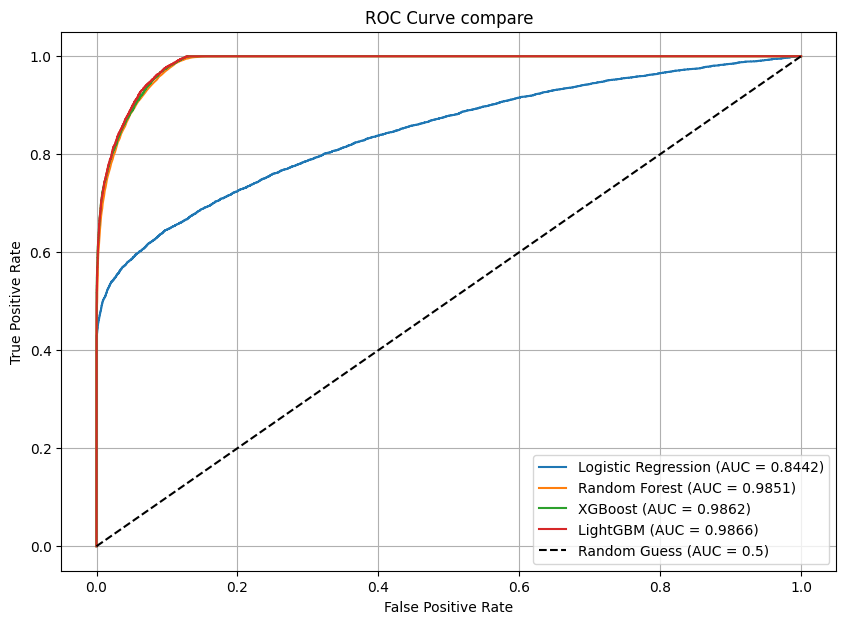

In [82]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# 모델명과 모델 객체 딕셔너리
models = {
    'Logistic Regression': lr_clf_final,
    'Random Forest': rf_clf,
    'XGBoost': xgb_clf,
    'LightGBM': lgbm_clf
}

plt.figure(figsize=(10, 7))

for name, model in models.items():
    # predict_proba의 positive class 확률만 추출 (1번째 컬럼)
    y_probs = model.predict_proba(X_test)[:, 1]

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_probs)
    auc_score = roc_auc_score(y_test, y_probs)

    # Plot
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc_score:.4f})")

# Random guess 선
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess (AUC = 0.5)')

plt.title('ROC Curve compare')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(True)
plt.show()